# Graded Exercise 2: Anomaly Detection on Acoustic Data

- **Course**: [CIVIL-426 - Machine Learning for Predictive Maintenance](https://edu.epfl.ch/coursebook/en/machine-learning-for-predictive-maintenance-applications-CIVIL-426)
- **Start Date**: 2024.10.03 at 10:15
- **Due Date**: 2024.10.16 at 23:59
- **Student 0**:
    - Name: `Lars Quaedvlieg`
    - SCIPER: `352130`
- **Student 1**:
    - Name: `FILL HERE`
    - SCIPER: `FILL HERE`

# Introduction
Anomalous sound detection (ASD) refers to the task of identifying whether the sounds emitted from a target machine are normal or anomalous.
In real-world industrial environments, anomalies are infrequent and can exhibit significant variability, making it impractical to build an exhaustive set of anomalous sound patterns.
As a result, our goal is to detect anomalous sounds using only normal sound clips for training.

This challenge cannot be approached as a simple classification problem (anomaly vs healthy). Instead, it is formulated as a **one-class classification** problem, where the model is trained on normal sound data to detect deviations from the learned pattern.

Anomalous sound detection can be achieved with following steps:
   - Feature Extraction (I)
   - One-class Classifier Training (II)
   - Decisions based on a threshold from your trained classifier (III)
   
Through this assignment, you will primarily focus on tasks (I) and (II).
The quality of your one-class classifier will be assessed using the **Area Under the Curve (AUC)** score on the test dataset.

The model used here is a type of neural network called **AutoEncoder** (AE). AE is trained to reconstruct the input data while compressing the input data into a lower-dimensional latent space and minimizing information loss during this process.
Thus, you will also modify the extracted features and Neural Network used in this notebook to improve the anomalous sound detection performance.

The dataset is composed of two different machines, a Pump and a Valve. For each machine you have:
- A **training dataset** composed of *only healthy* sound data
- A **test dataset** composed of *both healthy and abnormal* sound data

# Questions:

Your task is to improve the anomalous sound detection performance by modifying the feature extraction process and neural network architecture. You are expected to experiment with various feature representations and neural network configurations to optimize detection results.

Specifically, the following questions must be addressed. Each question should be discussed separately for both the Pump and Valve datasets. The answers are to be provided in a PDF report, and the full Jupyter notebook must also be submitted.

**Question 1:** Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

**Question 2:** From the trained AutoEncoder, use the bottleneck features to train both (1) a One-Class SVM and (2) an Isolation Forest, and report the corresponding AUC scores.

**Question 3:** Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

**Question 4:** Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

**Question 5:** Visualize essential steps and provide a thorough discussion of the results obtained from all the methods.  

**Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

## Download Dataset

In [1]:
# %pip install gdown --upgrade --quiet
# import gdown

In [2]:
# # Pump Dataset
# gdown.download(id='1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn', output="./dev_data_pump_04.zip")

In [3]:
# # Valve Dataset
# gdown.download(id='1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M', output="./dev_data_valve_00.zip")

In case that above links do not work, you can also manully download the dataset here:
- **dev_data_pump_04.zip**: https://docs.google.com/uc?export=download&id=1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn
- **dev_data_valve_00,zip**: https://docs.google.com/uc?export=download&id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M

In [4]:
# !unzip dev_data_pump_04.zip
# !unzip dev_data_valve_00.zip

## Import Dependency

In [1]:
import os
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import sklearn

## Audio Data Loading and MEL-Spectrogram Feature Extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [2]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# WAV File Input
def load_wav_files(wav_file_name, mono=True):
    """Load a .wav file."""
    try:
        return librosa.load(wav_file_name, sr=None, mono=mono)
    except Exception as e:
        print(f"Failed to load file '{wav_file_name}'. Error: {e}")
        raise

def demux_wav_files(wav_file_name, channel=0):
    """Demux a .wav file and return a specific channel."""
    try:
        multi_channel_data, sr = load_wav_files(wav_file_name, mono=False)
        if multi_channel_data.ndim == 1:
            return sr, multi_channel_data
        return sr, multi_channel_data[channel, :]
    except ValueError as e:
        print(f"Error in demuxing file '{wav_file_name}': {e}")
        raise

# Feel free to modify and analysis the images in your report
def plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram):
    plt.figure(1)
    n = len(y)
    t = np.linspace(tmin, tmax, n)
    plt.plot(t, y)
    plt.xlim(t[0],t[-1])
    plt.xlabel('Time/s',fontsize=14)
    plt.ylabel('Amplitude',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.savefig('out/sample_signal.png')
    
    plt.figure(2)
    freq = sr/n*np.linspace(0,n/2,int(n/2)+1)
    plt.plot(freq,np.absolute(np.fft.rfft(y[tmin*sr:tmax*sr],n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    plt.savefig('out/sample_fft1.png')

    plt.figure(3)
    plt.plot(freq,np.absolute(np.fft.rfft(emphasized_y,n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    plt.savefig('out/sample_fft2.png')

    plt.figure(4)
    librosa.display.specshow(log_mel_spectrogram)
    plt.xlabel('Time/s',fontsize=14)
    plt.ylabel('Frequency/Hz',fontsize=14)
    plt.colorbar()
    plt.savefig('out/sample_spec.png')

########################################################################
# Feature Extractor
########################################################################
def file_to_features(file_name,
                     n_mels=64,
                     frames=5,
                     n_fft=1024,
                     hop_length=512,
                     power=2.0,
                     plot=True):
    """Convert a WAV file to a vector array."""
    # Step 01: Load the demuxed wav files
    sr, y = demux_wav_files(file_name, channel=0)
    
    # Step 02: Signal Pre-emphasis
    tmin = int(0)
    tmax = int(len(y)/sr)
    alpha = 0.95
    emphasized_y = np.append(y[0],
                             y[1:] - alpha*y[:-1])
    
    # Step 03: Generate MEL-Spectrogram
    # ===================================
    # IMPLEMENT YOUR CODE HERE
    # ===================================
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_fft=n_fft, 
        hop_length=hop_length,
        power=power,
        n_mels=n_mels,
    )
    
    # Step 04: Convert MEL-Spectrogram to log scale
    # ===================================
    # IMPLEMENT YOUR CODE HERE
    # ===================================
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Step 05: Define Feature Vector Array
    dims = n_mels * frames
    length = len(log_mel_spectrogram[0,:]) - frames + 1
    features = np.zeros((length, dims), float)
    
    # Pad short clips instead of skipping
    if length < 1:
        print(f"Audio file '{file_name}' is too short. Padding applied.")
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, frames - 1)), mode='constant')
        length = 1
    
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + length].T
    
    if plot:
        plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram)
    return features

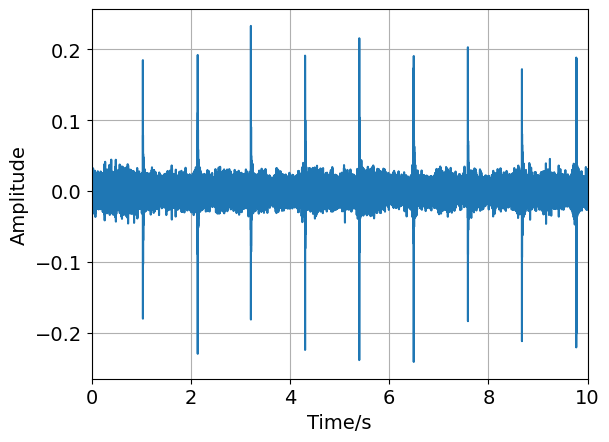

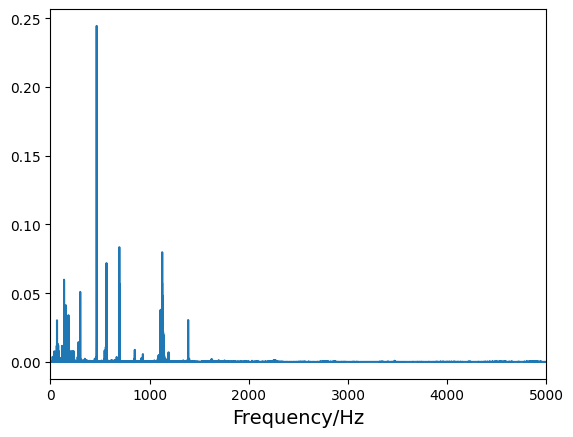

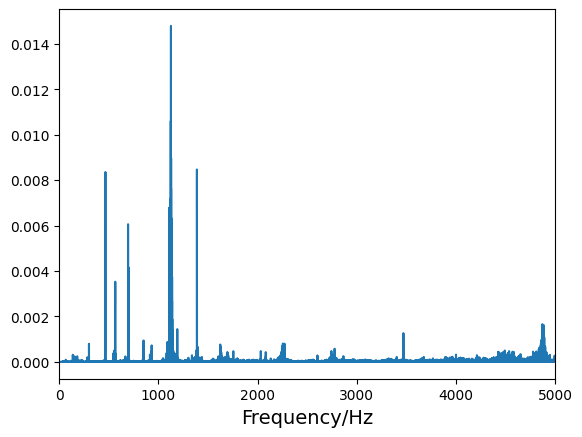

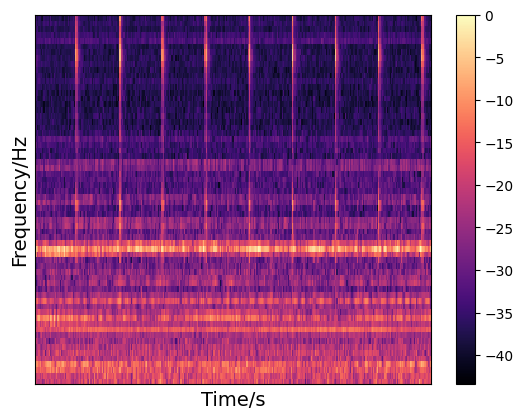

In [3]:
wav_test_file = 'dev_data_valve_00/valve/train/normal_id_00_00000001.wav' #'dev_data_pump_04/pump/train/normal_id_04_00000000.wav' 
# wav_test_file = 'dev_data_pump_04/pump/test/anomaly_id_04_00000000.wav'

# Visualize your results for potential analysis in your report
features = file_to_features(wav_test_file)

## PyTorch Dataset Splitting

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [4]:
DATA_PATH = "."
MACHINE = "valve_00" #"pump_04" # Choice between  "valve_00" or "pump_04"

In [5]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_features(file_path).astype(np.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [6]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=1,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0,
                    plot=False)

# Should be different for pump and valve
# Mean and standard deviation for standardization
FEATURE_MEAN = -26.4661
FEATURE_STD = 9.0894 

feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_features(file, **melsp_params).astype(np.float32)),
    T.Lambda(lambda x: (x - FEATURE_MEAN) / FEATURE_STD),  # Standardize features
    T.ToTensor()
])

In [7]:
# Pytorch train/test datasets
data_train = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=True,
    transform=feature_extraction_pipeline
)

data_test = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=False,
    transform=feature_extraction_pipeline
)

In [8]:
# all_values = []
# for sample in tqdm(data_train):
#     all_values.extend([v.item() for v in sample[0].flatten()])

In [9]:
# vs = torch.tensor(all_values)
# print(vs.mean().item(), vs.std().item())

# plt.figure()
# plt.hist(all_values)
# plt.xlabel("Feature Value")
# plt.ylabel("Count")
# plt.savefig('out/stand_feats.png')
# plt.show()

## AutoEncoder Model Definition

In [10]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim, latent_space_dim=32):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_space_dim),
        )
        
        # TODO : write a symetrical neural network to the encoder to reconstuct the input
        # ===================================
        # IMPLEMENT YOUR CODE HERE
        # ===================================
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_space_dim=32):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: (16, 157, 32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 79, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 40, 8)
            nn.ReLU()
        )

        # Flatten layer
        self.flatten = nn.Flatten()  # Output: (batch_size, 64 * 40 * 8)
        self.fc1 = nn.Linear(64 * 40 * 8, latent_space_dim)  # Latent space representation
        self.fc2 = nn.Linear(latent_space_dim, 64 * 40 * 8)  # Reconstruct flattened input

        # Decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 40, 8)),  # Reshape back to convolutional format
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),  # (32, 79, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),  # (16, 157, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),  # (1, 313, 64)
        )

    def forward(self, x):
        # Encoding step
        feature = self.encoder(x)
        feature = self.flatten(feature)
        feature = self.fc1(feature)  # Latent representation
        
        # Decoding step
        reconstruction = self.fc2(feature)
        reconstruction = self.decoder(reconstruction)
        
        return reconstruction, feature

In [94]:
duration = 10  # s 
sr = 16000  # Hz
# Before bug fix: int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
input_dims = (int(duration * sr / melsp_params["hop_length"] + 1 - melsp_params["frames"] + 1), melsp_params["n_mels"] * melsp_params["frames"])
input_dim = input_dims[0] * input_dims[1]
model = DenseAutoencoder(input_dim, latent_space_dim=32).to('cuda') # ConvAutoencoder()

#!pip install torchsummary
if isinstance(model, ConvAutoencoder):
    from torchsummary import summary
    summary(model.to('cuda'), (1, 313, 64))
if isinstance(model, DenseAutoencoder):
    from torchsummary import summary
    summary(model.to('cuda'), (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]      10,256,896
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 128]          65,664
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 32]           4,128
            Linear-6               [-1, 1, 128]           4,224
              ReLU-7               [-1, 1, 128]               0
            Linear-8               [-1, 1, 512]          66,048
              ReLU-9               [-1, 1, 512]               0
           Linear-10             [-1, 1, 20032]      10,276,416
Total params: 20,673,376
Trainable params: 20,673,376
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.17
Params size (MB): 78.86
Esti

## Training

In [19]:
# Training parameters
batch_size = 32
epochs = 10

In [20]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [21]:
# Stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = nn.MSELoss()

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        x, y = x.to('cuda'), y.to('cuda')
        if isinstance(model, DenseAutoencoder):
            x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, features = model(x)
        
        # TODO : write the loss function, compute the gradient, and update the model parameters
        # ===================================
        # IMPLEMENT YOUR CODE HERE
        # ===================================
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()
        
        # Back Propagation
        loss_running += loss.item()

    epoch_loss = loss_running/len(dataloader)
    print(f"loss: {epoch_loss:>7f}")
    return epoch_loss

def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in tqdm(enumerate(dataset)):
            x = x[:, None, ...].to('cuda')
            if type(model) is not ConvAutoencoder:
                x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    features = np.array(store_feature)
    return test_losses, np.reshape(features, newshape=(features.shape[0], -1))

In [32]:
# Find the best latent space size
# Initialize a list to store results
results = []

# Training loop
for latent_space_size in [4, 8, 16, 32, 64]:   
    # Initialize model
    model = DenseAutoencoder(input_dim, latent_space_dim=latent_space_size).to('cuda')
    
    # PyTorch data loaders allow to iterate batch-wise over a dataset
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Stochastic gradient descent optimizer
    optimizer = torch.optim.Adam(model.parameters())
    
    # Mean Squared Error (MSE) loss function to be minimized
    loss_fn = nn.MSELoss()
    
    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} for latent space size {latent_space_size}\n-------------------------------")
        training_loss = train_loop(train_loader, model, loss_fn, optimizer, print_every=1)
        
        # Store results in the list
        results.append({
            'latent_space_size': latent_space_size,
            'epoch': epoch + 1,
            'loss': training_loss
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Step 4: Create a table of loss plots using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='epoch', y='loss', hue='latent_space_size', marker='o')
# plt.title('Training Loss by Latent Space Size')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.legend(title='Latent Space Size', loc='upper right')
plt.grid()
plt.tight_layout()
plt.savefig('out/dense_latent_sizes.png')
plt.show()

In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, print_every=1);

In [95]:
# Saving the model so we don't have to keep re-training
output_dir_path = 'out'
save_mode = False
load_mode = True

os.makedirs(output_dir_path, exist_ok=True)
model_path = os.path.join(output_dir_path, 'dense_model.pt') #conv_model.pt
if save_mode:
    torch.save(model.state_dict(), model_path)
if load_mode:
    model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_210751/1137121901.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## Prediction and Evaluation

219it [00:05, 43.39it/s]


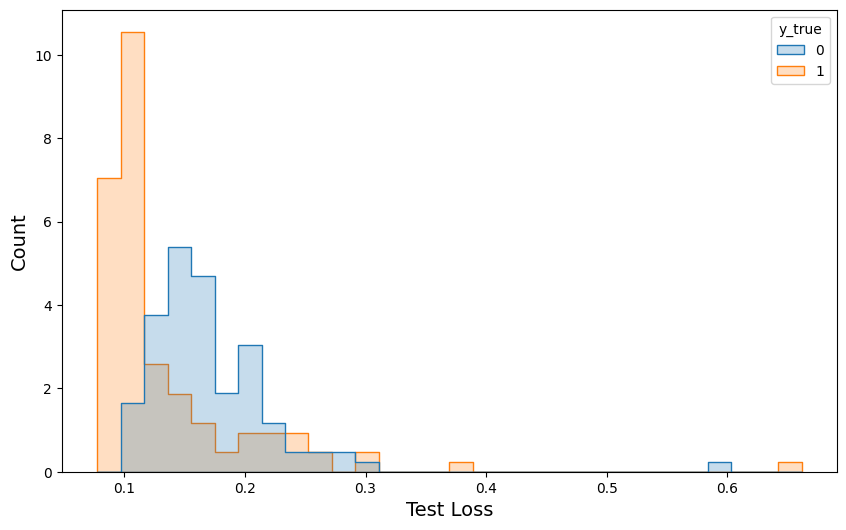

In [96]:
y_true = data_test.labels
test_losses, extracted_features_test = test_loop(data_test, model, loss_fn)
y_scores = test_losses

# Assuming y_true and y_scores are lists or numpy arrays
df = pd.DataFrame({
    'y_true': y_true,
    'y_scores': y_scores
})

# Plot histograms of the score distributions, grouped by the true labels
plt.figure(figsize=(10, 6))

# Using histplot to display the distributions
sns.histplot(data=df, x='y_scores', hue='y_true', bins=30, kde=False, element="step", stat="density")

# Add labels and title
plt.xlabel('Test Loss', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig('out/test_loss_dist.png')
# plt.title('Distribution of Test Losses by Anomalous samples (1) or healthy (0)')

# Show plot
plt.show()

AUC Score: 0.21453781512605044


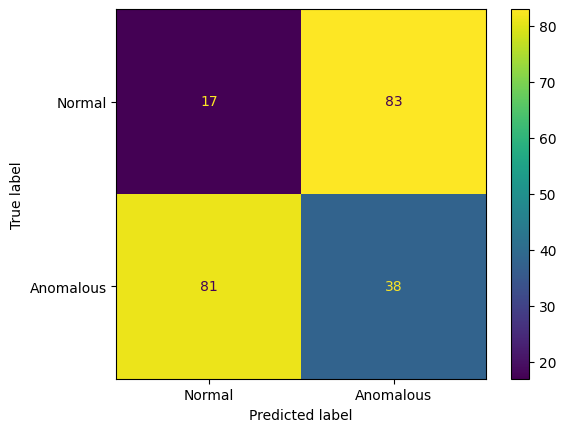

Accuracy: 0.2511415525114155
F1-score: 0.31666666666666665
TPR: 0.31932773109243695
FPR: 0.83
Classification report:
              precision    recall  f1-score   support

           0       0.17      0.17      0.17       100
           1       0.31      0.32      0.32       119

    accuracy                           0.25       219
   macro avg       0.24      0.24      0.24       219
weighted avg       0.25      0.25      0.25       219



In [98]:
print('AUC Score:', metrics.roc_auc_score(y_true, y_scores).item())

# TODO : Define a threshold based on test loss for classification
# TODO : Report accuracy, TPR, FPR, F1-Score
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================
loss_threshold = 0.13
y_pred = [1 if test_loss > loss_threshold else 0 for test_loss in test_losses]
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
(tn, fp), (fn, tp) = confusion_matrix[0], confusion_matrix[1]
display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=["Normal", "Anomalous"])
display.plot()
plt.show()
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_true, y_pred)}")
print(f"F1-score: {sklearn.metrics.f1_score(y_true, y_pred)}")
print(f"TPR: {tp / (tp + fn)}")
print(f"FPR: {fp / (fp + tn)}")

print('Classification report:')
print(sklearn.metrics.classification_report(y_true, y_pred))

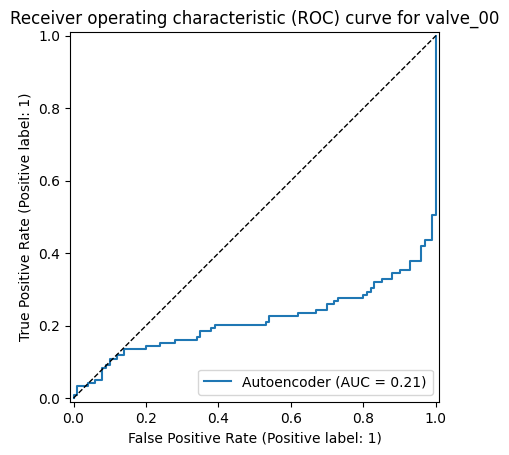

In [99]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_scores, name="Autoencoder")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"Receiver operating characteristic (ROC) curve for {MACHINE}");

## One-Class SVM and Isolation Forest

From the trained AutoEncoder, use the bottleneck features to train a (1) One-Class SVM and (2) Isolation Forest, and report the accuracy, F1-score and auc score of each method.

In [100]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [101]:
# Get normal training features
y_pred_train, extracted_features_train = test_loop(data_train, model, loss_fn)

891it [00:29, 30.45it/s]


### One-Class SVM

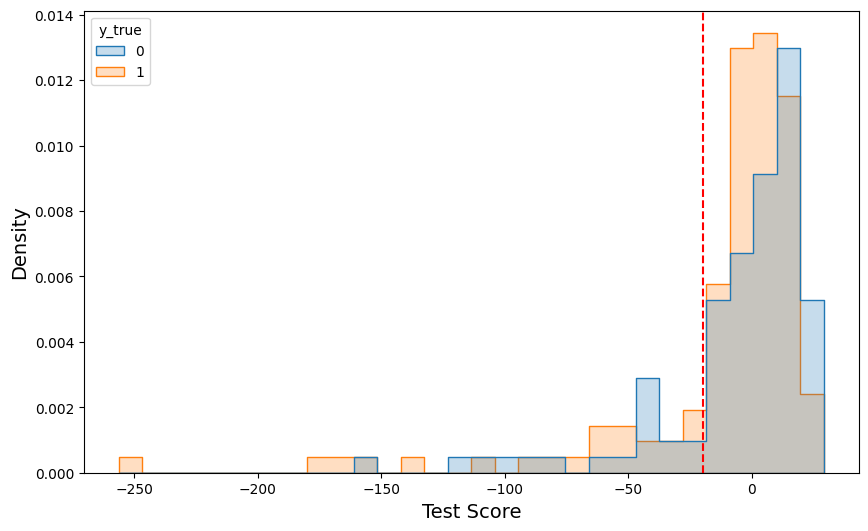

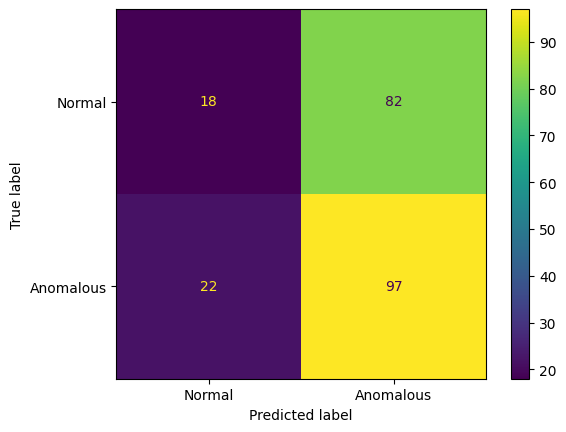

F1-score: 0.6510067114093959
Accuracy: 0.5251141552511416
TPR: 0.8151260504201681
FPR: 0.82

Classification report:
              precision    recall  f1-score   support

           0       0.45      0.18      0.26       100
           1       0.54      0.82      0.65       119

    accuracy                           0.53       219
   macro avg       0.50      0.50      0.45       219
weighted avg       0.50      0.53      0.47       219

ROC AUC Score: 0.4261344537815126


In [107]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using training data
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================
ocsvm = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.5)
ocsvm.fit(extracted_features_train)

predicted_score = ocsvm.decision_function(extracted_features_test)
ocsvm_threshold = -20

# Assuming y_true and y_scores are lists or numpy arrays
df = pd.DataFrame({
    'y_true': y_true,
    'y_scores': predicted_score,
})

# Plot histograms of the score distributions, grouped by the true labels
plt.figure(figsize=(10, 6))

# Using histplot to display the distributions
sns.histplot(data=df, x='y_scores', hue='y_true', bins=30, kde=False, element="step", stat="density")

# Add labels and title
plt.xlabel('Test Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.axvline(x=ocsvm_threshold, color='r', linestyle='dashed')
# plt.savefig('out/conv_osvm_score_dist.png')
# plt.title('Distribution of Test Losses by Anomalous samples (1) or healthy (0)')

# Show plot
plt.show()

y_pred_test = (predicted_score > ocsvm_threshold).astype(int)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred_test)
(tn, fp), (fn, tp) = confusion_matrix[0], confusion_matrix[1]
display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=["Normal", "Anomalous"])
display.plot()
plt.show()
print(f"F1-score: {sklearn.metrics.f1_score(y_true, y_pred_test)}")
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_true, y_pred_test)}")
print(f"TPR: {tp / (tp + fn)}")
print(f"FPR: {fp / (fp + tn)}")

print('\nClassification report:')
print(sklearn.metrics.classification_report(y_true, y_pred_test))

roc_auc = metrics.roc_auc_score(y_true, predicted_score).item()
print(f"ROC AUC Score: {roc_auc}")

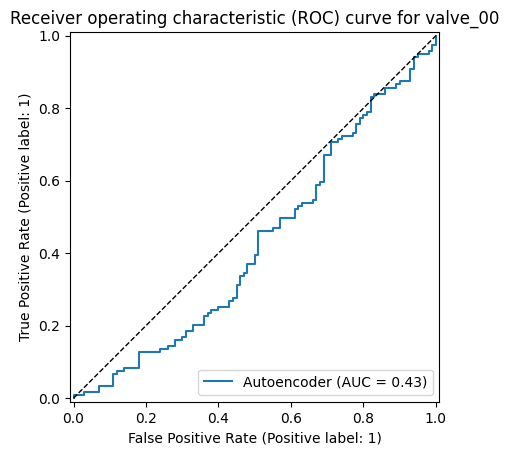

In [103]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, predicted_score, name="Autoencoder")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"Receiver operating characteristic (ROC) curve for {MACHINE}");

### Isolation Forest

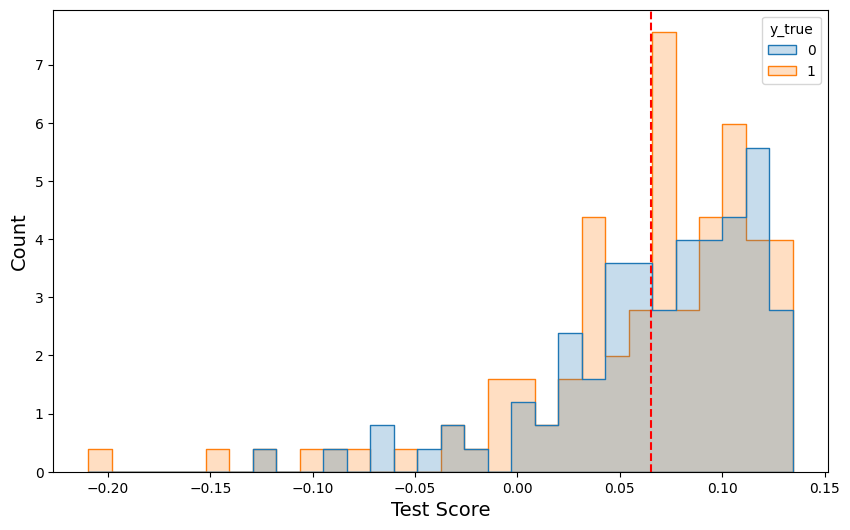

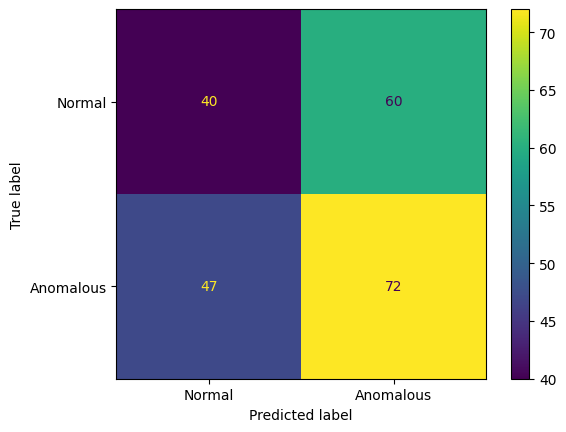

F1-score (Isolation Forest): 0.5737051792828686
Accuracy: 0.5114155251141552
TPR (Isolation Forest): 0.6050420168067226
FPR (Isolation Forest): 0.6

Classification report (Isolation Forest):
              precision    recall  f1-score   support

           0       0.46      0.40      0.43       100
           1       0.55      0.61      0.57       119

    accuracy                           0.51       219
   macro avg       0.50      0.50      0.50       219
weighted avg       0.51      0.51      0.51       219

Isolation Forest ROC AUC Score: 0.47403361344537814


In [108]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using training data
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=0)
iso_forest.fit(extracted_features_train)

predicted_score_iforest = iso_forest.decision_function(extracted_features_test)
iso_forest_threshold = 0.065

# Assuming y_true and y_scores are lists or numpy arrays
df = pd.DataFrame({
    'y_true': y_true,
    'y_scores': predicted_score_iforest,
})

# Plot histograms of the score distributions, grouped by the true labels
plt.figure(figsize=(10, 6))

# Using histplot to display the distributions
sns.histplot(data=df, x='y_scores', hue='y_true', bins=30, kde=False, element="step", stat="density")
plt.axvline(x=iso_forest_threshold, color='r', linestyle='dashed')

# Add labels and title
plt.xlabel('Test Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.savefig('out/test_loss_dist.png')
# plt.title('Distribution of Test Losses by Anomalous samples (1) or healthy (0)')

# Show plot
plt.show()

y_pred_test_iforest = (predicted_score_iforest > iso_forest_threshold).astype(int)

# Calculate confusion matrix and display for Isolation Forest
confusion_matrix_iforest = sklearn.metrics.confusion_matrix(y_true, y_pred_test_iforest)
(tn_if, fp_if), (fn_if, tp_if) = confusion_matrix_iforest[0], confusion_matrix_iforest[1]
display_iforest = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix_iforest, display_labels=["Normal", "Anomalous"])
display_iforest.plot()
plt.show()

# Evaluation metrics for IsolationForest
print(f"F1-score (Isolation Forest): {sklearn.metrics.f1_score(y_true, y_pred_test_iforest)}")
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_true, y_pred_test_iforest)}")
print(f"TPR (Isolation Forest): {tp_if / (tp_if + fn_if)}")
print(f"FPR (Isolation Forest): {fp_if / (fp_if + tn_if)}")

print('\nClassification report (Isolation Forest):')
print(sklearn.metrics.classification_report(y_true, y_pred_test_iforest))

roc_auc_iforest = sklearn.metrics.roc_auc_score(y_true, predicted_score_iforest).item()
print(f"Isolation Forest ROC AUC Score: {roc_auc_iforest}")

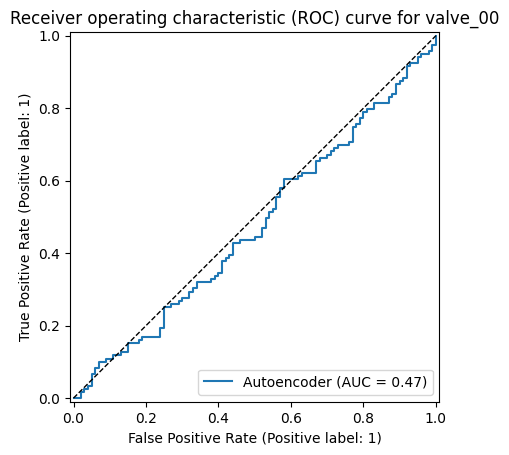

In [109]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, predicted_score_iforest, name="Autoencoder")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"Receiver operating characteristic (ROC) curve for {MACHINE}");

PCA of the spectrograms to reduce the input dimension

In [81]:
# Extract spectrograms of training and testing
flatten_spectogram_train = []
for idx, (x, _) in enumerate(data_train):
    x = x.flatten()
    flatten_spectogram_train.append(x.numpy())
train_spec = np.array(flatten_spectogram_train)

flatten_spectogram_test = []
for idx, (x, _) in enumerate(data_test):
    x = x.flatten()
    flatten_spectogram_test.append(x.numpy())
test_spec = np.array(flatten_spectogram_test)

Apply PCA to fit and transform the training data and transform also the test data

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)

# TODO : Fit and transform the training data (train_spec)
# TODO : Transform the testing data (test_spec)
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================
train_spec_pca = pca.fit_transform(train_spec)
test_spec_pca = pca.transform(test_spec)

Apply OneClassSVM and IsolationForest on the new PCA features.

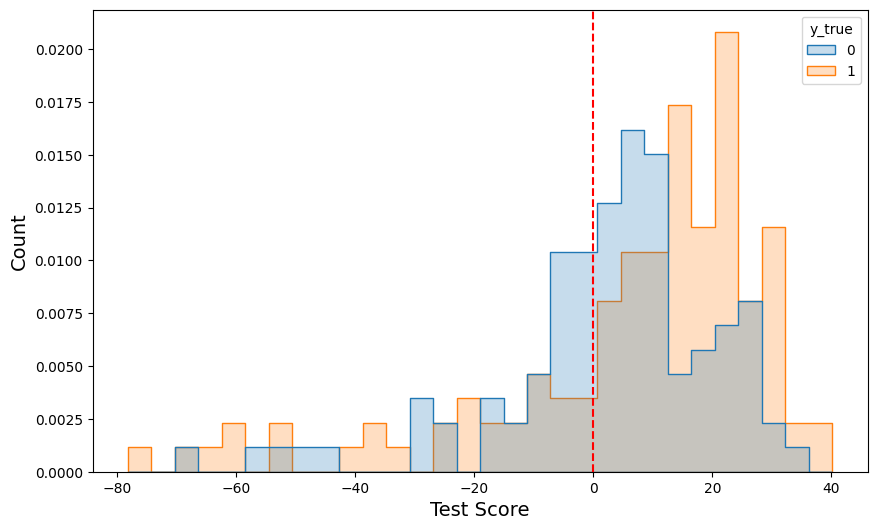

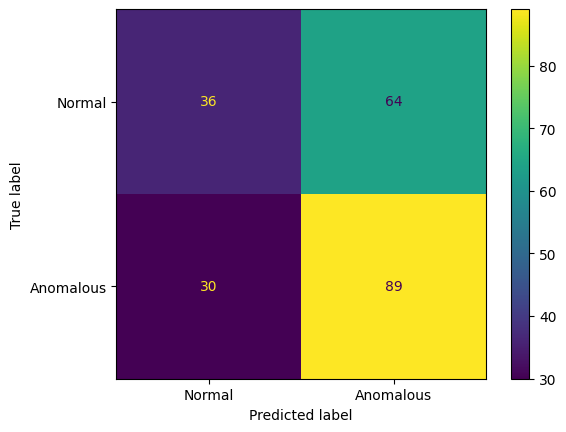

F1-score: 0.6544117647058824
Accuracy: 0.5707762557077626
TPR: 0.7478991596638656
FPR: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.36      0.43       100
           1       0.58      0.75      0.65       119

    accuracy                           0.57       219
   macro avg       0.56      0.55      0.54       219
weighted avg       0.57      0.57      0.55       219

ROC AUC Score: 0.6210924369747899


In [85]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================
ocsvm = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.5)
ocsvm.fit(train_spec_pca)

predicted_score = ocsvm.decision_function(test_spec_pca)
ocsvm_threshold = 0

# Assuming y_true and y_scores are lists or numpy arrays
df = pd.DataFrame({
    'y_true': y_true,
    'y_scores': predicted_score,
})

# Plot histograms of the score distributions, grouped by the true labels
plt.figure(figsize=(10, 6))

# Using histplot to display the distributions
sns.histplot(data=df, x='y_scores', hue='y_true', bins=30, kde=False, element="step", stat="density")
plt.axvline(x=ocsvm_threshold, color='r', linestyle='dashed')

# Add labels and title
plt.xlabel('Test Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.savefig('out/test_loss_dist.png')
# plt.title('Distribution of Test Losses by Anomalous samples (1) or healthy (0)')

# Show plot
plt.show()

y_pred_test = (predicted_score > ocsvm_threshold).astype(int)

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred_test)
(tn, fp), (fn, tp) = confusion_matrix[0], confusion_matrix[1]
display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=["Normal", "Anomalous"])
display.plot()
plt.show()
print(f"F1-score: {sklearn.metrics.f1_score(y_true, y_pred_test)}")
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_true, y_pred_test)}")
print(f"TPR: {tp / (tp + fn)}")
print(f"FPR: {fp / (fp + tn)}")

print('\nClassification report:')
print(sklearn.metrics.classification_report(y_true, y_pred_test))

roc_auc = metrics.roc_auc_score(y_true, predicted_score).item()
print(f"ROC AUC Score: {roc_auc}")

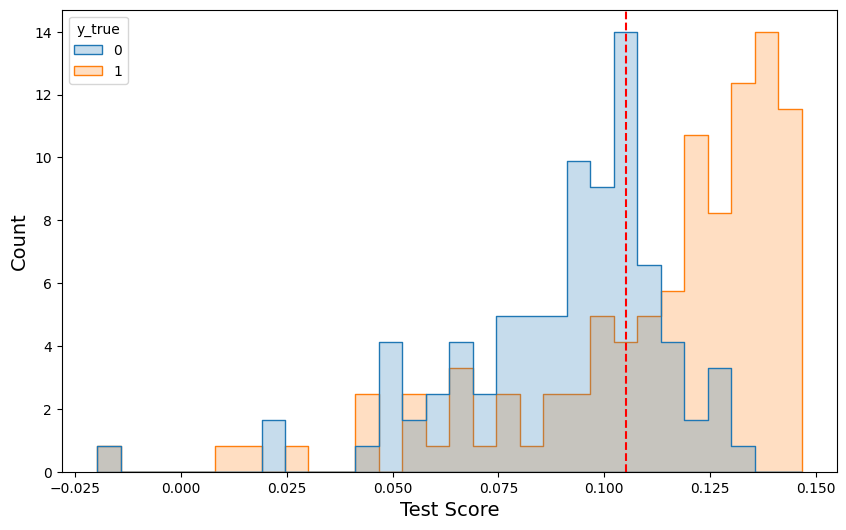

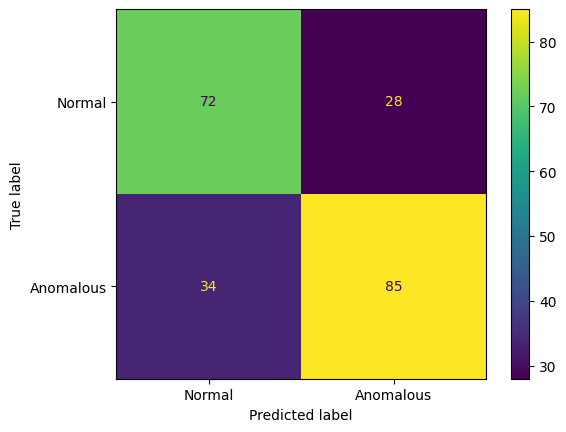

F1-score (Isolation Forest): 0.7327586206896551
Accuracy (Isolation Forest): 0.7168949771689498
TPR (Isolation Forest): 0.7142857142857143
FPR (Isolation Forest): 0.28

Classification report (Isolation Forest):
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       100
           1       0.75      0.71      0.73       119

    accuracy                           0.72       219
   macro avg       0.72      0.72      0.72       219
weighted avg       0.72      0.72      0.72       219

Isolation Forest ROC AUC Score: 0.7683193277310926


In [93]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=0)
iso_forest.fit(train_spec_pca)

predicted_score_iforest = iso_forest.decision_function(test_spec_pca)
iso_forest_threshold = 0.105

# Assuming y_true and y_scores are lists or numpy arrays
df = pd.DataFrame({
    'y_true': y_true,
    'y_scores': predicted_score_iforest,
})

# Plot histograms of the score distributions, grouped by the true labels
plt.figure(figsize=(10, 6))

# Using histplot to display the distributions
sns.histplot(data=df, x='y_scores', hue='y_true', bins=30, kde=False, element="step", stat="density")
plt.axvline(x=iso_forest_threshold, color='r', linestyle='dashed')

# Add labels and title
plt.xlabel('Test Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.savefig('out/test_loss_dist.png')
# plt.title('Distribution of Test Losses by Anomalous samples (1) or healthy (0)')

# Show plot
plt.show()

y_pred_test_iforest = (predicted_score_iforest > iso_forest_threshold).astype(int)

# Calculate confusion matrix and display for Isolation Forest
confusion_matrix_iforest = sklearn.metrics.confusion_matrix(y_true, y_pred_test_iforest)
(tn_if, fp_if), (fn_if, tp_if) = confusion_matrix_iforest[0], confusion_matrix_iforest[1]
display_iforest = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix_iforest, display_labels=["Normal", "Anomalous"])
display_iforest.plot()
plt.show()

# Evaluation metrics for IsolationForest
print(f"F1-score (Isolation Forest): {sklearn.metrics.f1_score(y_true, y_pred_test_iforest)}")
print(f"Accuracy (Isolation Forest): {sklearn.metrics.accuracy_score(y_true, y_pred_test_iforest)}")
print(f"TPR (Isolation Forest): {tp_if / (tp_if + fn_if)}")
print(f"FPR (Isolation Forest): {fp_if / (fp_if + tn_if)}")

print('\nClassification report (Isolation Forest):')
print(sklearn.metrics.classification_report(y_true, y_pred_test_iforest))

roc_auc_iforest = sklearn.metrics.roc_auc_score(y_true, predicted_score_iforest).item()
print(f"Isolation Forest ROC AUC Score: {roc_auc_iforest}")